# Intro

This notebook is mainly focused on experimenting with different Large Vision Models available in the Hugging Face Transformers and Ollama libraries. The main goals of this experiment are:

1. To determine if using LVMs in order to create content related features of memes is a viable methodology.
2. If so, what are the best models to use for this task, taking into consideration the available computational resources.
3. What type of prompts are best suited to classify memes into the correct category, and what taxonomy should be used for this task.
4. Estimate the inference time and the upper limit of the dataset size that can be processed in a reasonable amount of time.
5. Get familiar with the syntax used in the Hugging Face Transformers and Ollama libraries.

### Models

The models that will be tested are:
- [llava 1.6 7b & 13b](https://ollama.com/library/llava)
- [llava-llama3 8b](https://ollama.com/library/llava-llama3)
- [llava-phi3 3.8b](https://ollama.com/library/llava-phi3)
- [Ovis1.6-Gemma2-9B](https://huggingface.co/AIDC-AI/Ovis1.6-Gemma2-9B)
- [Qwen2-VL-7B-Instruct](https://huggingface.co/Qwen/Qwen2-VL-7B-Instruct)

The choice of the models was informed based on the resolutions of the images in the dataset (done in this notebook), as well as model leaderboards available in Hugging Face (listed below) and the available computational resoruces.
- [OpenVLM Leaderboard](https://huggingface.co/spaces/opencompass/open_vlm_leaderboard)
- [WildVision Arena Leaderboard](https://huggingface.co/spaces/WildVision/vision-arena)

### Taxonomy
The taxonomy used for this experiment is the suggested by [this paper](https://kuscholarworks.ku.edu/bitstream/handle/1808/10256/Milner_ku_0099D_12255_DATA_1.pdf?sequence=1) (check page 83 onwards). The summary of the taxonomy and corresponding examples from the paper are provided below:

![taxonomy_general](../assets/taxonomy_general.png) ![taxonomy_examples](../assets/taxonomy_examples.png)



---
## Importing Libraries & Setting Up

In [ ]:
import os
import sys

sys.path.append(os.path.abspath("../"))

import logging
import re

import matplotlib.pyplot as plt
import ollama
import pandas as pd
import seaborn as sns
import utils
from matplotlib.ticker import MaxNLocator
from PIL import Image

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
)

/home/martim-esteves1/reddit-memes/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---
## Analyzing Image Resolutions

### Calculating Image Sizes and Aspect Ratio

In [2]:
# Read the posts datasets and pre-filter the columns
df_raw = pd.read_csv(
    filepath_or_buffer=r"../Data Collection Functions/new_rmemes23_posts.csv",
    usecols=[
        "author",
        #'author_created_utc',
        "created_utc",
        "id",
        "num_comments",
        "permalink",
        "title",
        "score",
        "url",
        "subreddit_subscribers",
        "total_awards_received",
        "selftext",
    ],
)
# Reorder columns
df_raw = df_raw[
    [
        "id",
        "author",
        #'author_created_utc',
        "created_utc",
        "title",
        "selftext",
        "score",
        "subreddit_subscribers",
        "num_comments",
        "total_awards_received",
        "permalink",
        "url",
    ]
]

display(df_raw.head())

,id,author,created_utc,title,selftext,score,subreddit_subscribers,num_comments,total_awards_received,permalink,url
0,15v9uaw,neerajanchan,1692431595,It looks like….umm never mind!,NaN,1,27059555,25,0,/r/memes/comments/15v9uaw/it_looks_likeumm_nev...,https://i.redd.it/4ob2kkv1w0jb1.jpg
1,164cv6s,1minuteryan,1693298652,Name a country not on the list without using G...,NaN,1,27229214,60,0,/r/memes/comments/164cv6s/name_a_country_not_o...,https://i.redd.it/hy6kljp3i0lb1.jpg
2,15pdqiu,mortsGB,1691869730,Slinkies never went down the stairs when i use...,NaN,1,26948045,18,0,/r/memes/comments/15pdqiu/slinkies_never_went_...,https://i.redd.it/4btd9hbchqhb1.jpg
3,160tlkj,FeelingDesigner,1692953564,How the hell is the French Bulldog now the mos...,NaN,1,27165388,481,0,/r/memes/comments/160tlkj/how_the_hell_is_the_...,https://i.redd.it/6ikffdf3z7kb1.png
4,15r4mcb,oranke_dino,1692041744,Allegedly.,NaN,1,26979939,27,0,/r/memes/comments/15r4mcb/allegedly/,https://i.redd.it/wn3pkeoto4ib1.jpg


In [ ]:
# Define parallelized function to get the image size
@utils.parallelize(6)
def get_image_size(
    image_dir: str, post_id: str
) -> tuple[int, int] | tuple[None, None]:
    """
    Get the size of an image (width and height) based on the input id.
    Images must bealready downloaded. If the image is not found,
    None tuple is returned.

    Parameters
    ----------
    image_dir : str
        The path to the directory where the images are stored.
    post_id : str
        The id of the post/image.

    Returns
    -------
    tuple[int, int] | tuple[None, None]
        The width and height of the image if found, otherwise None tuple.

    Raises
    ------
    FileNotFoundError
        If the image directory is not found.
    """
    if os.path.exists(image_dir):
        try:
            image = Image.open(f"{image_dir}/{post_id}.jpeg")
        except FileNotFoundError:
            logging.exception(f"Image {post_id} not found.")
            return None, None
        else:
            return image.size
    else:
        logging.error(f"Directory {image_dir} not found.")
        raise FileNotFoundError()

In [4]:
# Check that all images are .jpeg
image_dir = "../Data Collection Functions/downloaded_images/r-memes/2023"
pattern = re.compile(r"\.(jpeg)$", re.IGNORECASE)

count_jpeg = 0
images_total = len(os.listdir(image_dir))
for file in os.listdir(image_dir):
    if pattern.search(file):
        count_jpeg += 1

print(
    f"Number of JPEG images: {count_jpeg}, out of {images_total} images"
    f"({round(count_jpeg / images_total * 100, 2)}%)."
)

del pattern, count_jpeg, images_total

Number of JPEG images: 76213, out of 76213 images(100.0%).


In [ ]:
# Get the image size
df_raw[["width", "height"]] = (
    df_raw["id"]
    .apply(lambda post_id: get_image_size(image_dir, post_id))
    .apply(pd.Series)
)

2024-11-04 00:22:53,506 - ERROR - Image 18k075k not found.
2024-11-04 00:22:55,324 - ERROR - Image 18u0mbi not found.
2024-11-04 00:22:55,333 - ERROR - Image 18fx3z6 not found.
2024-11-04 00:22:56,767 - ERROR - Image 1303vg4 not found.
2024-11-04 00:22:58,244 - ERROR - Image 160u8nm not found.
2024-11-04 00:23:00,804 - ERROR - Image 15uyc75 not found.
2024-11-04 00:23:01,512 - ERROR - Image 18p1hf8 not found.
2024-11-04 00:23:01,597 - ERROR - Image 18jrnrt not found.
2024-11-04 00:23:01,690 - ERROR - Image 18s08e1 not found.
2024-11-04 00:23:01,939 - ERROR - Image 18jojvg not found.
2024-11-04 00:23:01,966 - ERROR - Image 18itol4 not found.
2024-11-04 00:23:02,055 - ERROR - Image 18m0nlp not found.
2024-11-04 00:23:02,242 - ERROR - Image 18ij8fs not found.
2024-11-04 00:23:02,277 - ERROR - Image 18kqcrl not found.
2024-11-04 00:23:02,338 - ERROR - Image 18m6hi1 not found.
2024-11-04 00:23:02,450 - ERROR - Image 18qovkr not found.
2024-11-04 00:23:02,725 - ERROR - Image 18puegu not foun

In [6]:
df_raw["aspect_ratio"] = df_raw["width"] / df_raw["height"]
display(df_raw.head())
display(df_raw[df_raw["width"].isnull()])

,id,author,created_utc,title,selftext,score,subreddit_subscribers,num_comments,total_awards_received,permalink,url,width,height,aspect_ratio
0,15v9uaw,neerajanchan,1692431595,It looks like….umm never mind!,NaN,1,27059555,25,0,/r/memes/comments/15v9uaw/it_looks_likeumm_nev...,https://i.redd.it/4ob2kkv1w0jb1.jpg,720.0,813.0,0.885609
1,164cv6s,1minuteryan,1693298652,Name a country not on the list without using G...,NaN,1,27229214,60,0,/r/memes/comments/164cv6s/name_a_country_not_o...,https://i.redd.it/hy6kljp3i0lb1.jpg,577.0,432.0,1.335648
2,15pdqiu,mortsGB,1691869730,Slinkies never went down the stairs when i use...,NaN,1,26948045,18,0,/r/memes/comments/15pdqiu/slinkies_never_went_...,https://i.redd.it/4btd9hbchqhb1.jpg,1080.0,1038.0,1.040462
3,160tlkj,FeelingDesigner,1692953564,How the hell is the French Bulldog now the mos...,NaN,1,27165388,481,0,/r/memes/comments/160tlkj/how_the_hell_is_the_...,https://i.redd.it/6ikffdf3z7kb1.png,997.0,1001.0,0.996004
4,15r4mcb,oranke_dino,1692041744,Allegedly.,NaN,1,26979939,27,0,/r/memes/comments/15r4mcb/allegedly/,https://i.redd.it/wn3pkeoto4ib1.jpg,960.0,1149.0,0.835509


,id,author,created_utc,title,selftext,score,subreddit_subscribers,num_comments,total_awards_received,permalink,url,width,height,aspect_ratio
1666,18k075k,EvaInTheUSA,1702759470,“Why don’t they ever bring back previous prota...,NaN,20244,28886649,303,0,/r/memes/comments/18k075k/why_dont_they_ever_b...,https://i.redd.it/yv6r7dq2yp6c1.gif,NaN,NaN,NaN
5215,18u0mbi,yinyang98,1703892266,Prepare to die then :),NaN,34,29097290,0,0,/r/memes/comments/18u0mbi/prepare_to_die_then/,https://i.redd.it/posxbb9iib9c1.gif,NaN,NaN,NaN
5234,18fx3z6,Firey_Piranha2,1702308568,Golden Globes about to be lit,NaN,27,28836950,1,0,/r/memes/comments/18fx3z6/golden_globes_about_...,https://i.redd.it/9tkqkhrbpo5c1.gif,NaN,NaN,NaN
8013,1303vg4,antisepticeye12,1682553486,Ghost buster,NaN,1,26877477,1,0,/r/memes/comments/1303vg4/ghost_buster/,https://i.redd.it/55d43tnshbwa1.png,NaN,NaN,NaN
10867,160u8nm,Ordinary-Bag5811,1692955709,New trump drop incoming,NaN,1,27165645,1,0,/r/memes/comments/160u8nm/new_trump_drop_incom...,https://i.redd.it/nhs9tiki68kb1.jpg,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56615,173oubv,TasteEducational2069,1696848713,The Essential Keto Cookbook (Physical) - Free ...,[removed],1,27882804,1,0,/r/memes/comments/173oubv/the_essential_keto_c...,https://i.redd.it/1v9hgnteq5tb1.png,NaN,NaN,NaN
56886,17iwsfj,Killurself4me,1698560285,so thats how its made,NaN,1,28171949,0,0,/r/memes/comments/17iwsfj/so_thats_how_its_made/,https://i.redd.it/s1spfe5r33xb1.jpg,NaN,NaN,NaN
59188,16cuwtb,Technical_Data_5353,1694131112,Descuentos para los 10 primeros 😮‍💨,[removed],1,27388318,1,0,/r/memes/comments/16cuwtb/descuentos_para_los_...,https://i.redd.it/0sre244l9xmb1.jpg,NaN,NaN,NaN
67846,18ueyzg,EvaInTheUSA,1703940597,Always gotta have that info memorized.,NaN,1462,29105793,4,0,/r/memes/comments/18ueyzg/always_gotta_have_th...,https://i.redd.it/7hf825i6if9c1.gif,NaN,NaN,NaN


### Plotting Image Sizes and Aspect Ratio

#### With Outliers

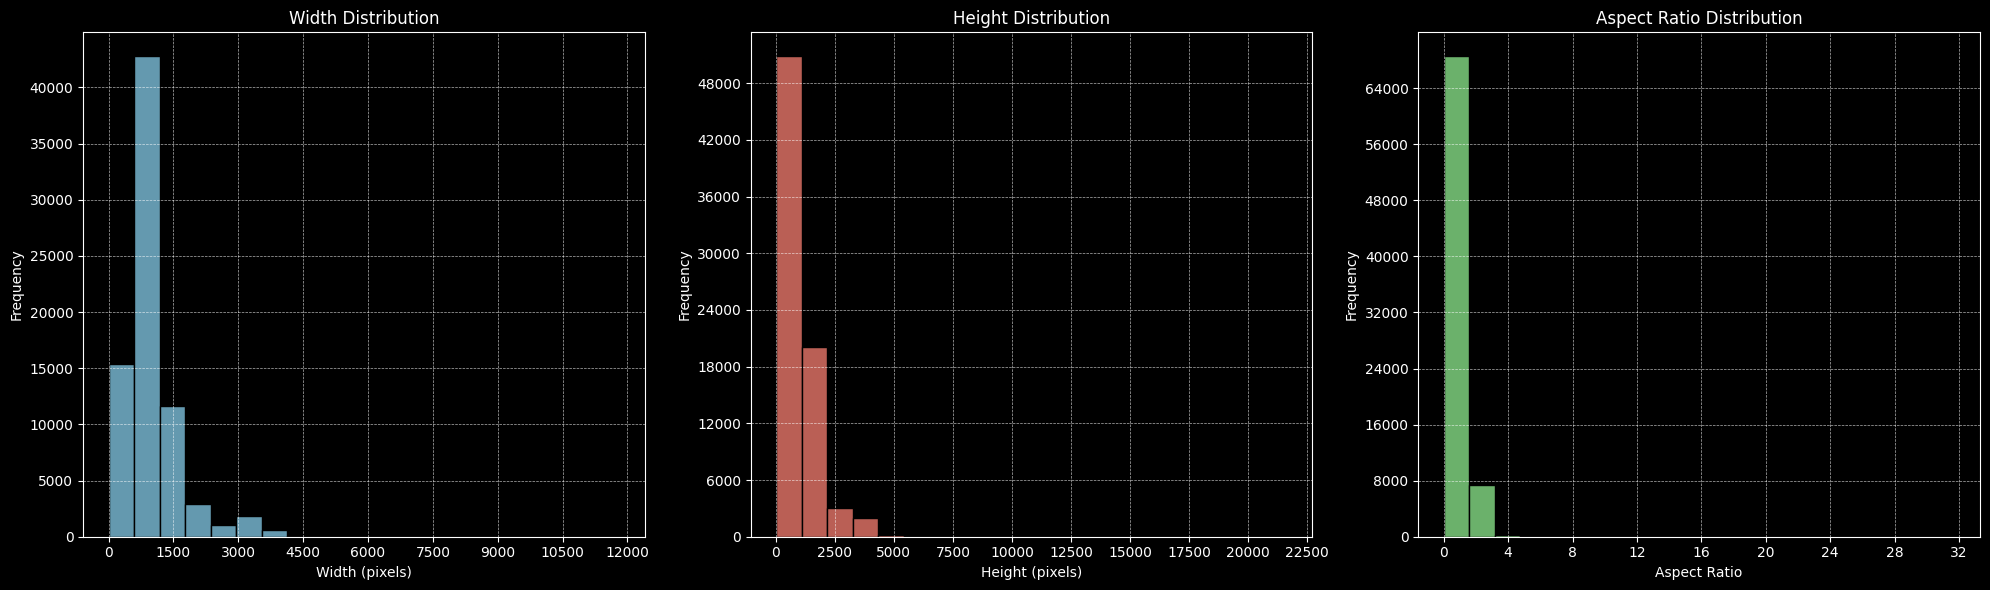

In [7]:
# Histograms
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

# Width Histogram
sns.histplot(
    data=df_raw["width"], ax=ax[0], bins=20, color="skyblue", edgecolor="black"
)
ax[0].set_title("Width Distribution")
ax[0].set_xlabel("Width (pixels)")
ax[0].set_ylabel("Frequency")
ax[0].xaxis.set_major_locator(MaxNLocator(nbins=10))
ax[0].yaxis.set_major_locator(MaxNLocator(nbins=10))
ax[0].grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

# Height Histogram
sns.histplot(
    data=df_raw["height"], ax=ax[1], bins=20, color="salmon", edgecolor="black"
)
ax[1].set_title("Height Distribution")
ax[1].set_xlabel("Height (pixels)")
ax[1].set_ylabel("Frequency")
ax[1].xaxis.set_major_locator(MaxNLocator(nbins=10))
ax[1].yaxis.set_major_locator(MaxNLocator(nbins=10))
ax[1].grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

# Aspect Ratio Histogram
sns.histplot(
    data=df_raw["aspect_ratio"],
    ax=ax[2],
    bins=20,
    color="lightgreen",
    edgecolor="black",
)
ax[2].set_title("Aspect Ratio Distribution")
ax[2].set_xlabel("Aspect Ratio")
ax[2].set_ylabel("Frequency")
ax[2].xaxis.set_major_locator(MaxNLocator(nbins=10))
ax[2].yaxis.set_major_locator(MaxNLocator(nbins=10))
ax[2].grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()

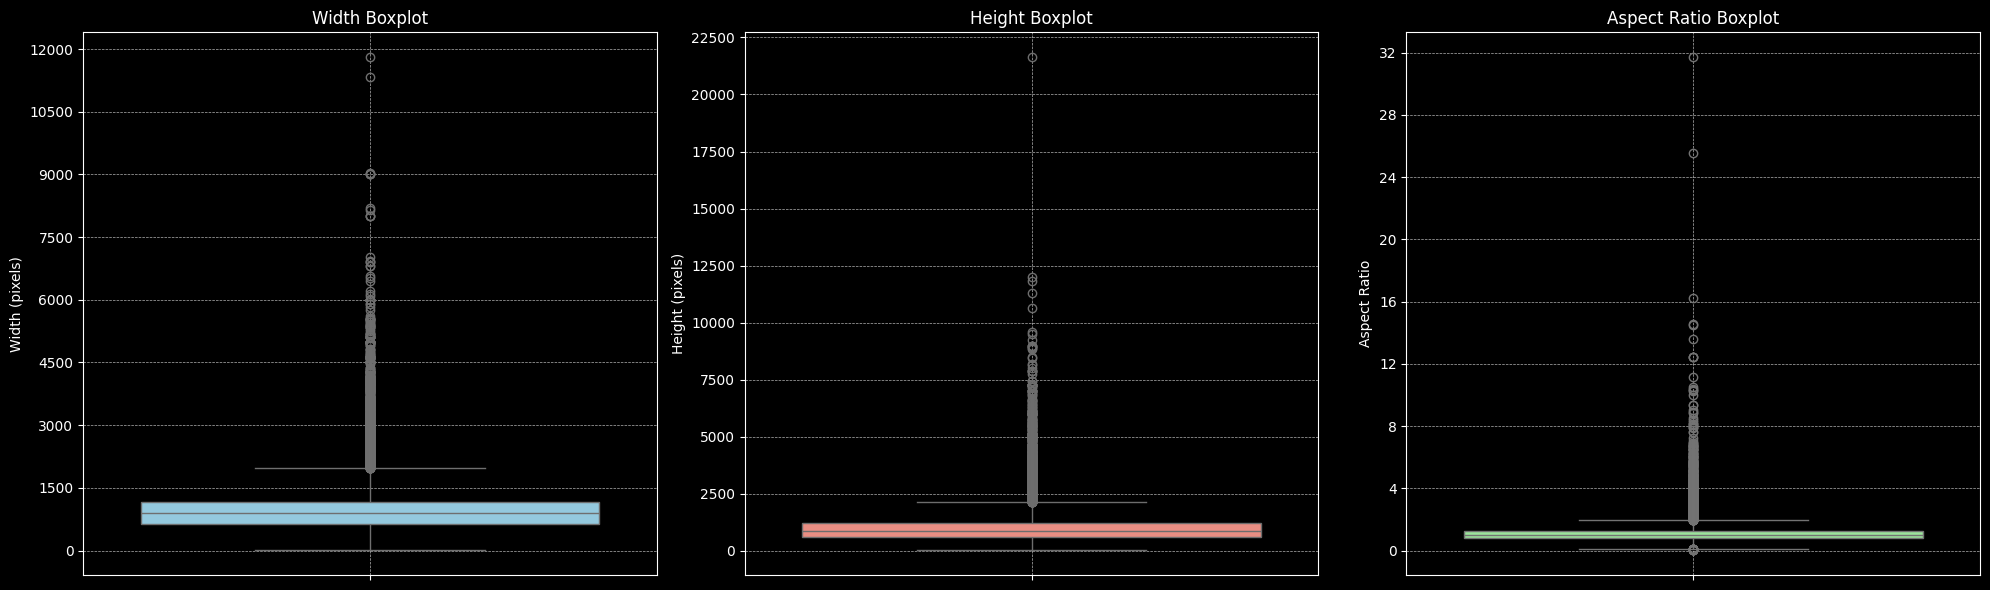

In [8]:
# Boxplots
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

# Width Boxplot
sns.boxplot(data=df_raw["width"], ax=ax[0], color="skyblue")
ax[0].set_title("Width Boxplot")
ax[0].set_ylabel("Width (pixels)")
ax[0].yaxis.set_major_locator(MaxNLocator(nbins=10))
ax[0].grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

# Height Boxplot
sns.boxplot(data=df_raw["height"], ax=ax[1], color="salmon")
ax[1].set_title("Height Boxplot")
ax[1].set_ylabel("Height (pixels)")
ax[1].yaxis.set_major_locator(MaxNLocator(nbins=10))
ax[1].grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

# Aspect Ratio Boxplot
sns.boxplot(data=df_raw["aspect_ratio"], ax=ax[2], color="lightgreen")
ax[2].set_title("Aspect Ratio Boxplot")
ax[2].set_ylabel("Aspect Ratio")
ax[2].yaxis.set_major_locator(MaxNLocator(nbins=10))
ax[2].grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()

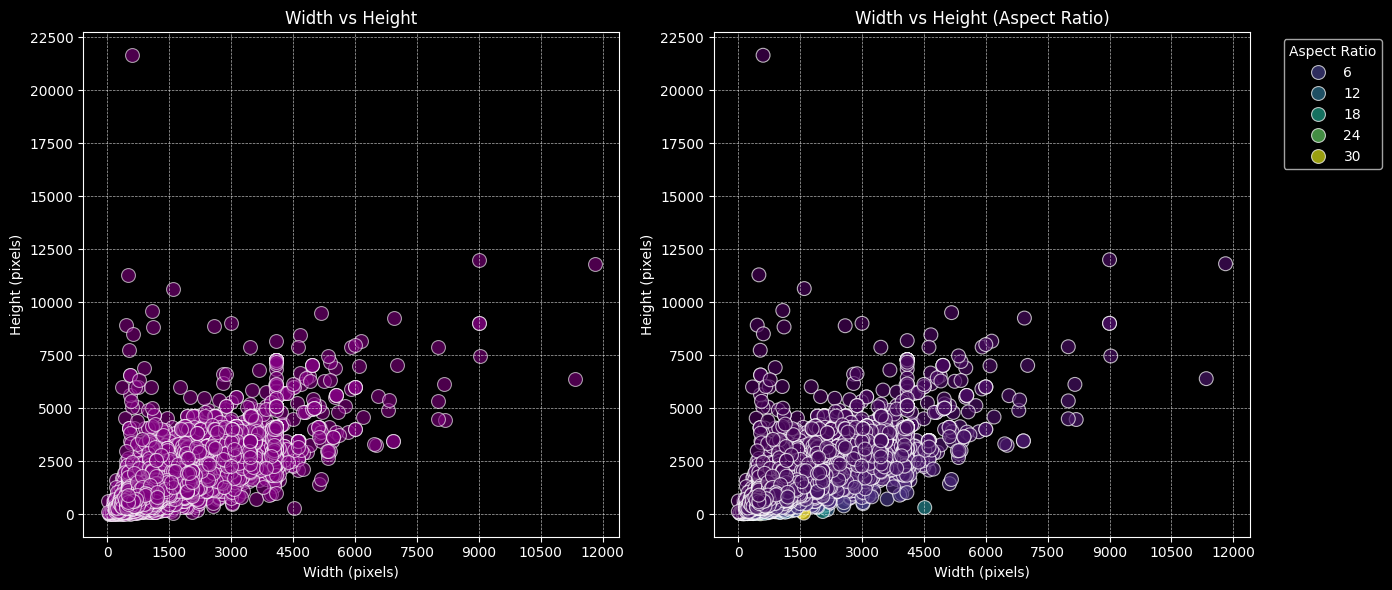

In [9]:
# Scatter plots
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Scatter Plot without Hue
scatter1 = sns.scatterplot(
    data=df_raw,
    x="width",
    y="height",
    ax=ax[0],
    color="purple",
    alpha=0.6,
    edgecolor="w",
    s=100,
)
ax[0].set_title("Width vs Height")
ax[0].set_xlabel("Width (pixels)")
ax[0].set_ylabel("Height (pixels)")
ax[0].xaxis.set_major_locator(MaxNLocator(nbins=10))
ax[0].yaxis.set_major_locator(MaxNLocator(nbins=10))
ax[0].grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

# Scatter Plot with Hue (Aspect Ratio)
scatter2 = sns.scatterplot(
    data=df_raw,
    x="width",
    y="height",
    hue="aspect_ratio",
    palette="viridis",
    ax=ax[1],
    alpha=0.7,
    edgecolor="w",
    s=100,
)
ax[1].set_title("Width vs Height (Aspect Ratio)")
ax[1].set_xlabel("Width (pixels)")
ax[1].set_ylabel("Height (pixels)")
ax[1].xaxis.set_major_locator(MaxNLocator(nbins=10))
ax[1].yaxis.set_major_locator(MaxNLocator(nbins=10))
ax[1].grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

# Adjust legend for the second plot
if "aspect_ratio" in df_raw.columns:
    ax[1].legend(
        title="Aspect Ratio", bbox_to_anchor=(1.05, 1), loc="upper left"
    )

plt.tight_layout()
plt.show()

#### Without Outliers

In [30]:
df_filtered = utils.remove_outliers_iqr(
    df_raw, ["width", "height", "aspect_ratio"], 3
)
display(df_filtered)

Removed 2845 outliers from width
Removed 697 outliers from height
Removed 547 outliers from aspect_ratio


,id,author,created_utc,title,selftext,score,subreddit_subscribers,num_comments,total_awards_received,permalink,url,width,height,aspect_ratio
0,15v9uaw,neerajanchan,1692431595,It looks like….umm never mind!,NaN,1,27059555,25,0,/r/memes/comments/15v9uaw/it_looks_likeumm_nev...,https://i.redd.it/4ob2kkv1w0jb1.jpg,720.0,813.0,0.885609
1,164cv6s,1minuteryan,1693298652,Name a country not on the list without using G...,NaN,1,27229214,60,0,/r/memes/comments/164cv6s/name_a_country_not_o...,https://i.redd.it/hy6kljp3i0lb1.jpg,577.0,432.0,1.335648
2,15pdqiu,mortsGB,1691869730,Slinkies never went down the stairs when i use...,NaN,1,26948045,18,0,/r/memes/comments/15pdqiu/slinkies_never_went_...,https://i.redd.it/4btd9hbchqhb1.jpg,1080.0,1038.0,1.040462
3,160tlkj,FeelingDesigner,1692953564,How the hell is the French Bulldog now the mos...,NaN,1,27165388,481,0,/r/memes/comments/160tlkj/how_the_hell_is_the_...,https://i.redd.it/6ikffdf3z7kb1.png,997.0,1001.0,0.996004
4,15r4mcb,oranke_dino,1692041744,Allegedly.,NaN,1,26979939,27,0,/r/memes/comments/15r4mcb/allegedly/,https://i.redd.it/wn3pkeoto4ib1.jpg,960.0,1149.0,0.835509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76276,10caao4,davidmcdavidsonson,1673756339,Sad but true,NaN,0,24196464,8,0,/r/memes/comments/10caao4/sad_but_true/,https://i.redd.it/x1pbxvhxc6ca1.jpg,1200.0,810.0,1.481481
76277,10a6qv1,huge_throbbing_pp,1673548096,I just don’t get it.,NaN,0,24196926,13,0,/r/memes/comments/10a6qv1/i_just_dont_get_it/,https://i.redd.it/540o0djynnba1.jpg,509.0,499.0,1.020040
76278,100byxg,Still-Anxiety-8261,1672547945,But for real,NaN,0,23513333,8,0,/r/memes/comments/100byxg/but_for_real/,https://i.redd.it/dqew603rje9a1.jpg,620.0,607.0,1.021417
76279,107b8hh,superbloggity,1673260548,Freud peed sittiing down,NaN,0,24197615,14,0,/r/memes/comments/107b8hh/freud_peed_sittiing_...,https://i.redd.it/c6vmotwvwzaa1.jpg,500.0,585.0,0.854701


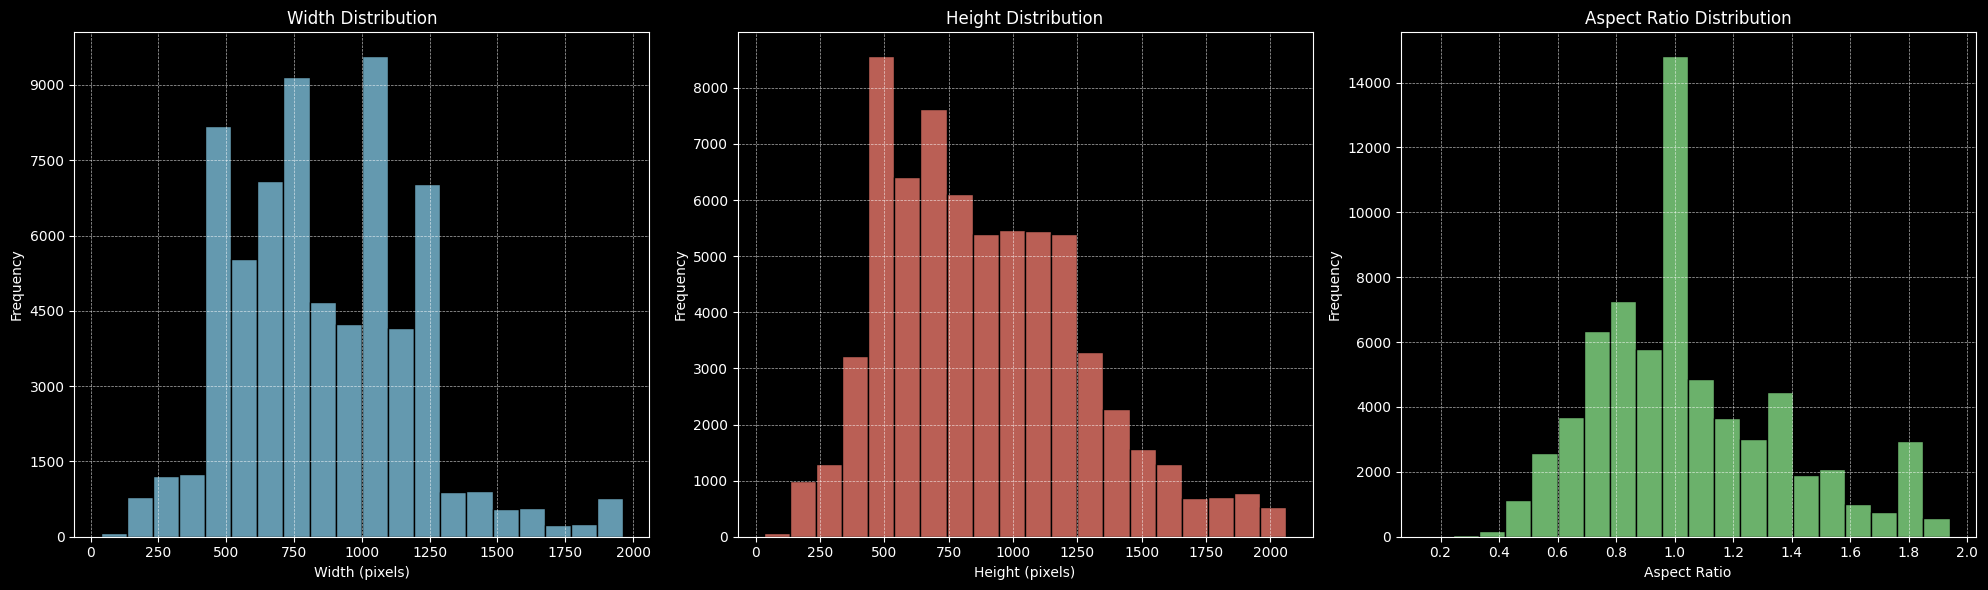

In [22]:
# Histograms
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

# Width Histogram
sns.histplot(
    data=df_filtered["width"],
    ax=ax[0],
    bins=20,
    color="skyblue",
    edgecolor="black",
)
ax[0].set_title("Width Distribution")
ax[0].set_xlabel("Width (pixels)")
ax[0].set_ylabel("Frequency")
ax[0].xaxis.set_major_locator(MaxNLocator(nbins=10))
ax[0].yaxis.set_major_locator(MaxNLocator(nbins=10))
ax[0].grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

# Height Histogram
sns.histplot(
    data=df_filtered["height"],
    ax=ax[1],
    bins=20,
    color="salmon",
    edgecolor="black",
)
ax[1].set_title("Height Distribution")
ax[1].set_xlabel("Height (pixels)")
ax[1].set_ylabel("Frequency")
ax[1].xaxis.set_major_locator(MaxNLocator(nbins=10))
ax[1].yaxis.set_major_locator(MaxNLocator(nbins=10))
ax[1].grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

# Aspect Ratio Histogram
sns.histplot(
    data=df_filtered["aspect_ratio"],
    ax=ax[2],
    bins=20,
    color="lightgreen",
    edgecolor="black",
)
ax[2].set_title("Aspect Ratio Distribution")
ax[2].set_xlabel("Aspect Ratio")
ax[2].set_ylabel("Frequency")
ax[2].xaxis.set_major_locator(MaxNLocator(nbins=10))
ax[2].yaxis.set_major_locator(MaxNLocator(nbins=10))
ax[2].grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()

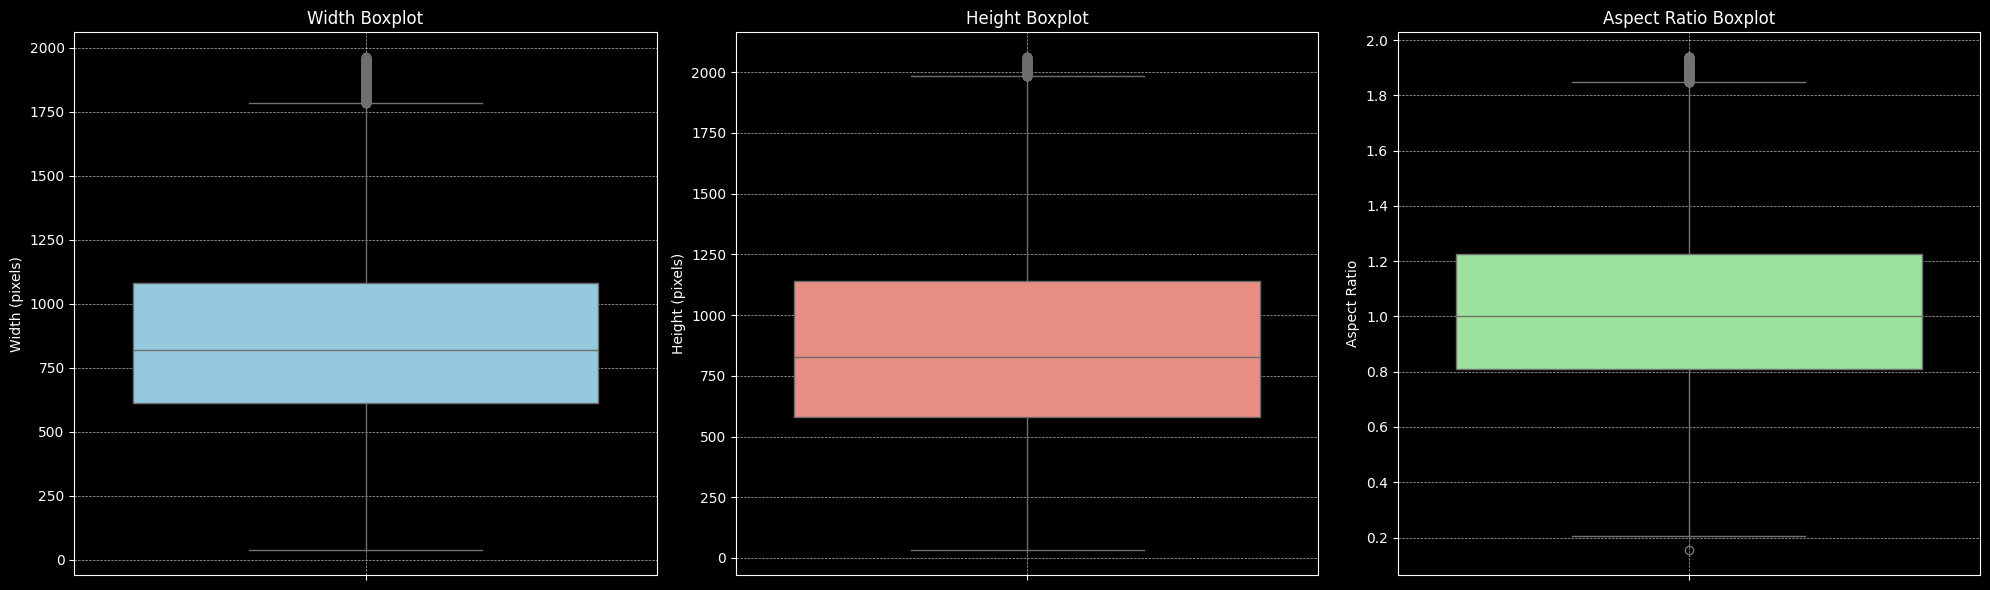

In [23]:
# Boxplots
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

# Width Boxplot
sns.boxplot(data=df_filtered["width"], ax=ax[0], color="skyblue")
ax[0].set_title("Width Boxplot")
ax[0].set_ylabel("Width (pixels)")
ax[0].yaxis.set_major_locator(MaxNLocator(nbins=10))
ax[0].grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

# Height Boxplot
sns.boxplot(data=df_filtered["height"], ax=ax[1], color="salmon")
ax[1].set_title("Height Boxplot")
ax[1].set_ylabel("Height (pixels)")
ax[1].yaxis.set_major_locator(MaxNLocator(nbins=10))
ax[1].grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

# Aspect Ratio Boxplot
sns.boxplot(data=df_filtered["aspect_ratio"], ax=ax[2], color="lightgreen")
ax[2].set_title("Aspect Ratio Boxplot")
ax[2].set_ylabel("Aspect Ratio")
ax[2].yaxis.set_major_locator(MaxNLocator(nbins=10))
ax[2].grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()

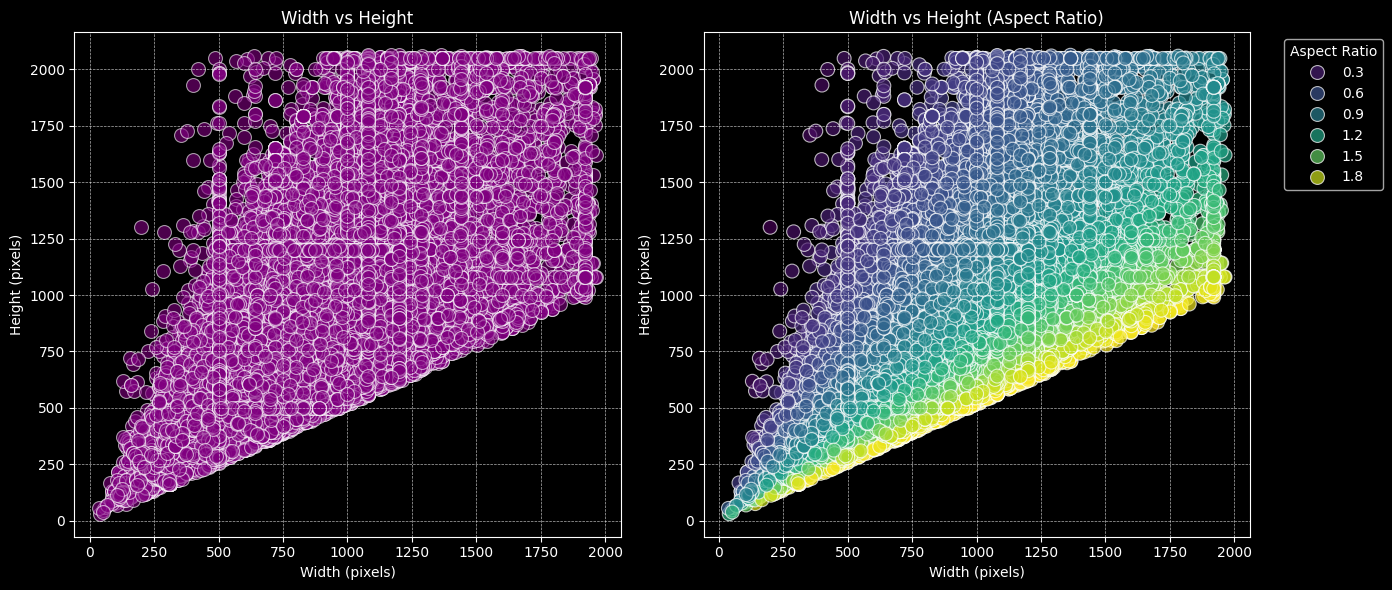

In [24]:
# Scatter plots
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Scatter Plot without Hue
scatter1 = sns.scatterplot(
    data=df_filtered,
    x="width",
    y="height",
    ax=ax[0],
    color="purple",
    alpha=0.6,
    edgecolor="w",
    s=100,
)
ax[0].set_title("Width vs Height")
ax[0].set_xlabel("Width (pixels)")
ax[0].set_ylabel("Height (pixels)")
ax[0].xaxis.set_major_locator(MaxNLocator(nbins=10))
ax[0].yaxis.set_major_locator(MaxNLocator(nbins=10))
ax[0].grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

# Scatter Plot with Hue (Aspect Ratio)
scatter2 = sns.scatterplot(
    data=df_filtered,
    x="width",
    y="height",
    hue="aspect_ratio",
    palette="viridis",
    ax=ax[1],
    alpha=0.7,
    edgecolor="w",
    s=100,
)
ax[1].set_title("Width vs Height (Aspect Ratio)")
ax[1].set_xlabel("Width (pixels)")
ax[1].set_ylabel("Height (pixels)")
ax[1].xaxis.set_major_locator(MaxNLocator(nbins=10))
ax[1].yaxis.set_major_locator(MaxNLocator(nbins=10))
ax[1].grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

# Adjust legend for the second plot
if "aspect_ratio" in df_filtered.columns:
    ax[1].legend(
        title="Aspect Ratio", bbox_to_anchor=(1.05, 1), loc="upper left"
    )

plt.tight_layout()
plt.show()

#### Outlier Specific Analysis

In [29]:
df_outliers = df_raw[~df_raw.index.isin(df_filtered.index)]
display(df_outliers)

,id,author,created_utc,title,selftext,score,subreddit_subscribers,num_comments,total_awards_received,permalink,url,width,height,aspect_ratio
25,15tw9hy,bluscorp91,1692298588,People hating Rachael for hating on a 86yr old...,NaN,1,27031018,18,0,/r/memes/comments/15tw9hy/people_hating_rachae...,https://i.redd.it/hu0zag0kwpib1.jpg,2048.0,2048.0,1.000000
37,15wxp0c,maskedmaniac2010,1692593962,Caption this image.,NaN,1,27094322,18,0,/r/memes/comments/15wxp0c/caption_this_image/,https://i.redd.it/ia7tx30uaejb1.png,2080.0,1497.0,1.389446
39,15y4p2l,ThewizardBlundermore,1692708047,Stop Making stupid people famous. The worst th...,NaN,1,27116657,406,3,/r/memes/comments/15y4p2l/stop_making_stupid_p...,https://i.redd.it/ygafls23qnjb1.jpg,2161.0,2793.0,0.773720
46,15tz2lm,nerrd42420,1692304850,Main character syndrome,NaN,1,27032714,20,0,/r/memes/comments/15tz2lm/main_character_syndr...,https://i.redd.it/j22eima6fqib1.jpg,2400.0,2400.0,1.000000
59,15osfmn,AngTheHunter,1691807631,"Sincerely, a canadian",NaN,1,26937174,116,0,/r/memes/comments/15osfmn/sincerely_a_canadian/,https://i.redd.it/7899fg4lclhb1.png,1500.0,2143.0,0.699953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76236,10cue9h,PaGeez2007,1673815485,I need help plz,NaN,0,24196318,12,0,/r/memes/comments/10cue9h/i_need_help_plz/,https://i.redd.it/qy9q6txs8bca1.jpg,1290.0,2796.0,0.461373
76246,108v1qr,brainharmer,1673410148,(image unrelated) I SWEAR TO GOD im making a r...,NaN,0,24197229,13,0,/r/memes/comments/108v1qr/image_unrelated_i_sw...,https://i.redd.it/ehk699ty9cba1.jpg,3840.0,2160.0,1.777778
76260,109e2p9,Azuthrial,1673466710,Just a few minutes ago,NaN,0,24197091,7,0,/r/memes/comments/109e2p9/just_a_few_minutes_ago/,https://i.redd.it/rpm69bnpfiba1.jpg,1948.0,2661.0,0.732056
76265,108vijs,OyDannyBoy,1673411517,In Praise of East Asian Women,NaN,0,24197227,14,0,/r/memes/comments/108vijs/in_praise_of_east_as...,https://i.redd.it/b4o7j5o1ecba1.jpg,5120.0,3657.0,1.400055


In [ ]:
# Examples of width outliers

In [ ]:
# Examples of height outliers

---
## Experimenting with Models

### Ollama Syntax

In [17]:
res = ollama.chat(
    model="llava",
    messages=[
        {
            "role": "user",
            "content": "How would you categorize this meme, between the categories of Macros, Stacked Stills, Comics or IRL memes",
            "images": ["10aj7gr.jpeg"],
        }
    ],
)

print(res["message"]["content"])

2024-11-04 00:25:07,259 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


 This meme appears to be a form of "Comics" meme, as it features a sequence of images with text that narrates a story. It combines elements from movies or other media, with the captions providing context and dialogue, similar to a comic strip. 


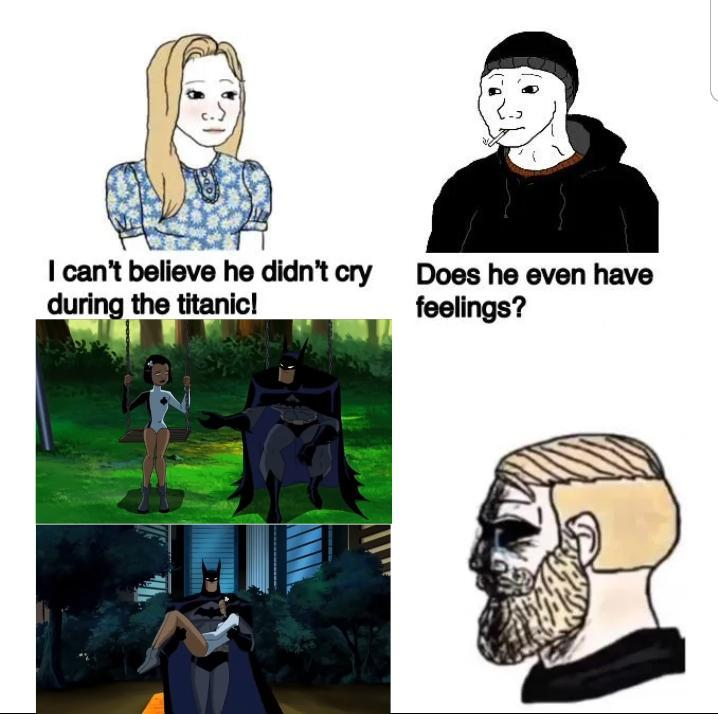

In [20]:
meme_1 = Image.open("10aj7gr.jpeg")

display(meme_1)